<a href="https://colab.research.google.com/github/alexandre-pinon/zoidberg-2.0/blob/main/zoidberg_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<header align="center">
  <h1>* T-DEV *</h1>
  <h1>~ Zoidberg 2.0 ~</h1>
  <p>
    <i>Alexandre.P | Bryan.S | Camille.V | Liza.H | Théo.M</i>
  </p>
  <img src="https://media.istockphoto.com/photos/robot-with-education-hud-picture-id966248982?k=20&m=966248982&s=612x612&w=0&h=gq35V9G0kfjKu0ttr90c8p0VraNtqPDkTvqWQ8oXzCk=" alt="AI img"/>
  <h2>Given some X-ray images, use machine learning to help doctors detecting pneumonia.</h2>
</header>

# Notebook config

## Constants

In [1]:
BINARY_DATASET_DIR = "datasets/chest_Xray_binary"
MULTI_DATASET_DIR = "datasets/chest_Xray_multi"
SEED = 12
IMG_SIZE = 224, 224
BATCH_SIZE = 32
EPOCHS = 10

## Load data & helpers

In [ ]:
!git clone -b colab-data "https://github.com/alexandre-pinon/zoidberg-2.0.git"

Cloning into 'zoidberg-2.0'...
remote: Enumerating objects: 5937, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 5937 (delta 6), reused 10 (delta 4), pack-reused 5925
Receiving objects: 100% (5937/5937), 1.14 GiB | 27.97 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Checking out files: 100% (11712/11712), done.


In [ ]:
!wget https://raw.githubusercontent.com/alexandre-pinon/zoidberg-2.0/main/helpers.py

--2022-04-29 12:47:46--  https://raw.githubusercontent.com/alexandre-pinon/zoidberg-2.0/main/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12393 (12K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]  12.10K  --.-KB/s    in 0s      

2022-04-29 12:47:46 (79.0 MB/s) - ‘helpers.py’ saved [12393/12393]



## Imports

In [2]:
import os
import pathlib
import random

import helpers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

from tensorflow.keras import Model, Sequential, layers, optimizers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [65]:
import importlib

importlib.reload(helpers)

<module 'helpers' from '/home/nowaffle/epitech/zoidberg-2.0/helpers.py'>

# Data analysis

## Datasets distribution

In [29]:
helpers.walk_through_dir(BINARY_DATASET_DIR)

There are 3 directories and 0 images in 'datasets/chest_Xray_binary'.
There are 2 directories and 0 images in 'datasets/chest_Xray_binary/val'.
There are 0 directories and 8 images in 'datasets/chest_Xray_binary/val/pneumonia'.
There are 0 directories and 8 images in 'datasets/chest_Xray_binary/val/normal'.
There are 2 directories and 0 images in 'datasets/chest_Xray_binary/test'.
There are 0 directories and 390 images in 'datasets/chest_Xray_binary/test/pneumonia'.
There are 0 directories and 234 images in 'datasets/chest_Xray_binary/test/normal'.
There are 2 directories and 0 images in 'datasets/chest_Xray_binary/train'.
There are 0 directories and 3875 images in 'datasets/chest_Xray_binary/train/pneumonia'.
There are 0 directories and 1341 images in 'datasets/chest_Xray_binary/train/normal'.


In [18]:
helpers.walk_through_dir(MULTI_DATASET_DIR)

There are 3 directories and 0 images in 'datasets/chest_Xray_multi'.
There are 2 directories and 0 images in 'datasets/chest_Xray_multi/val'.
There are 0 directories and 8 images in 'datasets/chest_Xray_multi/val/normal'.
There are 0 directories and 8 images in 'datasets/chest_Xray_multi/val/bacteria'.
There are 3 directories and 0 images in 'datasets/chest_Xray_multi/test'.
There are 0 directories and 148 images in 'datasets/chest_Xray_multi/test/virus'.
There are 0 directories and 234 images in 'datasets/chest_Xray_multi/test/normal'.
There are 0 directories and 242 images in 'datasets/chest_Xray_multi/test/bacteria'.
There are 3 directories and 0 images in 'datasets/chest_Xray_multi/train'.
There are 0 directories and 1345 images in 'datasets/chest_Xray_multi/train/virus'.
There are 0 directories and 1341 images in 'datasets/chest_Xray_multi/train/normal'.
There are 0 directories and 2530 images in 'datasets/chest_Xray_multi/train/bacteria'.


As we can see, the datasets are **unbalanced**:
* There is almost 3 times as more pneumonia images than normal images in the binary dataset
* There is almost 2 times as more bacteria images than normal and virus images in the binary dataset

There is no virus image in both val directories so we'll use it as a small graphical test dataset for **binary** classification only.

We need to **split** the train set to make our own validation set.

In [3]:
tf.random.set_seed(SEED)

In [4]:
binary_train_dir = f"{BINARY_DATASET_DIR}/train/"
multi_train_dir = f"{MULTI_DATASET_DIR}/train/"
val_dir = f"{BINARY_DATASET_DIR}/val/"
binary_test_dir = f"{BINARY_DATASET_DIR}/test/"
multi_test_dir = f"{MULTI_DATASET_DIR}/test/"

In [5]:
binary_class_names = sorted(os.listdir(binary_train_dir))
multi_class_names = sorted(os.listdir(multi_train_dir))

In [6]:
normal_train_img_count = len(os.listdir(f"{binary_train_dir}normal"))
pneumonia_train_img_count = len(os.listdir(f"{binary_train_dir}pneumonia"))
bacteria_train_img_count = len(os.listdir(f"{multi_train_dir}bacteria"))
virus_train_img_count = len(os.listdir(f"{multi_train_dir}virus"))

total_train_img_count = normal_train_img_count + pneumonia_train_img_count
assert (total_train_img_count == normal_train_img_count +
        bacteria_train_img_count + virus_train_img_count)


## Datasets visualization

Let's take a look at a few images of the train sets

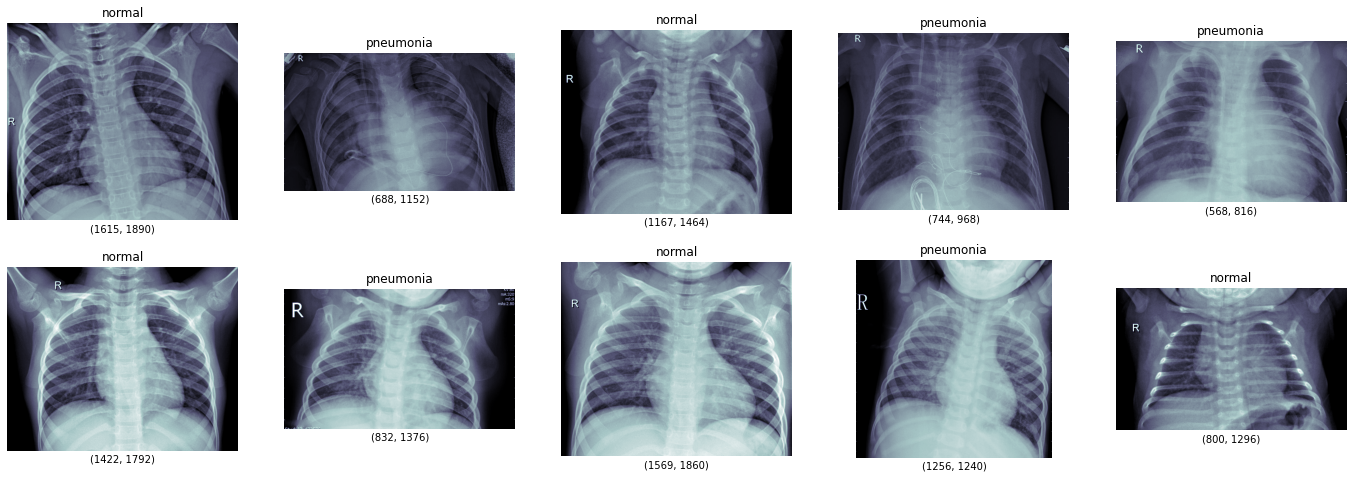

In [34]:
helpers.view_random_images(binary_train_dir, binary_class_names)

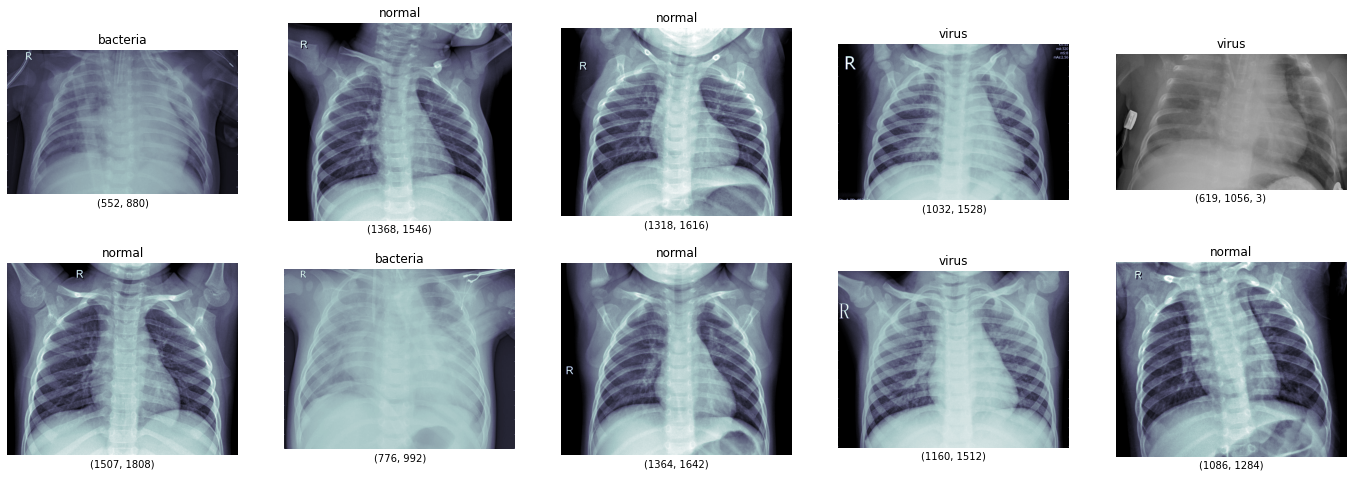

In [35]:
helpers.view_random_images(multi_train_dir, multi_class_names)

# Preprocessing

In [7]:
binary_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=binary_train_dir,
    image_size=IMG_SIZE,
    label_mode="binary",
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="training")

binary_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=binary_train_dir,
    image_size=IMG_SIZE,
    label_mode="binary",
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation")

binary_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=binary_test_dir,
    image_size=IMG_SIZE,
    label_mode="binary",
    shuffle=False)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.


2022-04-30 00:27:47.269343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-30 00:27:47.321007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-30 00:27:47.321290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-30 00:27:47.323540: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [8]:
multi_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=multi_train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="training")

multi_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=multi_train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation")

multi_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=multi_test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    shuffle=False)


Found 5216 files belonging to 3 classes.
Using 4173 files for training.
Found 5216 files belonging to 3 classes.
Using 1043 files for validation.
Found 624 files belonging to 3 classes.


## Data resizing & augmentation

>🔑 **Note**: You can check the configuration of the data augmentation in `helpers.py`

In [9]:
binary_train_data_augmented = helpers.preprocess_images(
    binary_train_data,
    seed=SEED,
    shuffle=True,
    augment=True,
    batch_size=BATCH_SIZE // 4)
binary_val_data_augmented = helpers.preprocess_images(binary_val_data,
                                                      seed=SEED,
                                                      batch_size=BATCH_SIZE //
                                                      4)
binary_test_data_augmented = helpers.preprocess_images(binary_test_data,
                                                       seed=SEED,
                                                       batch_size=BATCH_SIZE //
                                                       4)

multi_train_data_augmented = helpers.preprocess_images(multi_train_data,
                                                       seed=SEED,
                                                       shuffle=True,
                                                       augment=True,
                                                       batch_size=BATCH_SIZE //
                                                       4)
multi_val_data_augmented = helpers.preprocess_images(multi_val_data,
                                                     seed=SEED,
                                                     batch_size=BATCH_SIZE //
                                                     4)
multi_test_data_augmented = helpers.preprocess_images(multi_test_data,
                                                      seed=SEED,
                                                      batch_size=BATCH_SIZE //
                                                      4)


# Create models

## Fully connected dense models (baseline)

In [ ]:
inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = layers.Flatten()(inputs)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_dense_model = Model(inputs=inputs,
                           outputs=outputs,
                           name="binary_dense_model")
binary_dense_model.summary()

outputs = layers.Dense(len(multi_class_names),
                       activation="softmax",
                       name="output_layer")(x)
multi_dense_model = Model(inputs=inputs,
                          outputs=outputs,
                          name="multi_dense_model")
multi_dense_model.summary()

Model: "binary_dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 100)               15052900  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,07

## Basic CNN: Tiny VGG

In [ ]:
inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = layers.Conv2D(10, 3, activation='relu')(inputs)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_tiny_vgg = Model(inputs=inputs, outputs=outputs, name="binary_tiny_vgg")
binary_tiny_vgg.summary()

outputs = layers.Dense(len(multi_class_names),
                       activation="softmax",
                       name="output_layer")(x)
multi_tiny_vgg = Model(inputs=inputs, outputs=outputs, name="multi_tiny_vgg")
multi_tiny_vgg.summary()

Model: "binary_tiny_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                   

## Complex CNN: Densenet169

In [ ]:
base_model = tf.keras.applications.DenseNet169(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_169 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_169")
binary_densenet_169.summary()

outputs = layers.Dense(len(multi_class_names),
                       activation="softmax",
                       name="output_layer")(x)
multi_densenet_169 = Model(inputs=inputs,
                           outputs=outputs,
                           name="multi_densenet_169")
multi_densenet_169.summary()

51888128/51877672 [==============================] - 0s 0us/step
Model: "binary_densenet_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling_laye  (None, 1664)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________
Model: "multi_densenet_169"
____

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   0          ['rescaling_1[0][0]']            
 )                              3)                                                

# Train models (no preprocessing)

## Model compilations

In [ ]:
binary_models = [binary_dense_model, binary_tiny_vgg, binary_densenet_169]
binary_models_augmented = []
for binary_model in binary_models:
    model_copy = models.clone_model(binary_model)
    model_copy.set_weights(binary_model.get_weights())
    binary_models_augmented.append(model_copy)

multi_models = [multi_dense_model, multi_tiny_vgg, multi_densenet_169]
multi_models_augmented = []
for multi_model in multi_models:
    model_copy = models.clone_model(multi_model)
    model_copy.set_weights(multi_model.get_weights())
    multi_models_augmented.append(model_copy)

for binary_model in binary_models + binary_models_augmented:
    binary_model.compile(loss='binary_crossentropy',
                         optimizer=optimizers.Adam(),
                         metrics=["accuracy"])

for multi_model in multi_models + multi_models_augmented:
    multi_model.compile(loss='categorical_crossentropy',
                        optimizer=optimizers.Adam(),
                        metrics=["accuracy"])


## Model trainings

In [ ]:
binary_histories = [
    binary_model.fit(binary_train_data,
                     epochs=EPOCHS,
                     validation_data=binary_val_data,
                     verbose=False) for binary_model in binary_models
]

binary_histories_augmented = [
    binary_model.fit(binary_train_data_augmented,
                     epochs=EPOCHS,
                     validation_data=binary_val_data_augmented,
                     verbose=False) for binary_model in binary_models_augmented
]

multi_histories = [
    multi_model.fit(multi_train_data,
                    epochs=EPOCHS,
                    validation_data=multi_val_data,
                    verbose=False) for multi_model in multi_models
]

multi_histories_augmented = [
    multi_model.fit(multi_train_data_augmented,
                    epochs=EPOCHS,
                    validation_data=multi_val_data_augmented,
                    verbose=False) for multi_model in multi_models_augmented
]


## Model saving

In [ ]:
for binary_model in binary_models:
    binary_model.save(f'normal_models/{binary_model._name}')
for binary_model in binary_models_augmented:
    binary_model.save(f'augmented_models/{binary_model._name}')

for multi_model in multi_models:
    multi_model.save(f'normal_models/{multi_model._name}')
for multi_model in multi_models_augmented:
    multi_model.save(f'augmented_models/{multi_model._name}')


INFO:tensorflow:Assets written to: normal_models/binary_dense_model/assets
INFO:tensorflow:Assets written to: normal_models/binary_tiny_vgg/assets
INFO:tensorflow:Assets written to: normal_models/binary_densenet_169/assets
INFO:tensorflow:Assets written to: augmented_models/binary_dense_model/assets
INFO:tensorflow:Assets written to: augmented_models/binary_tiny_vgg/assets
INFO:tensorflow:Assets written to: augmented_models/binary_densenet_169/assets
INFO:tensorflow:Assets written to: normal_models/multi_dense_model/assets
INFO:tensorflow:Assets written to: normal_models/multi_tiny_vgg/assets
INFO:tensorflow:Assets written to: normal_models/multi_densenet_169/assets
INFO:tensorflow:Assets written to: augmented_models/multi_dense_model/assets
INFO:tensorflow:Assets written to: augmented_models/multi_tiny_vgg/assets
INFO:tensorflow:Assets written to: augmented_models/multi_densenet_169/assets


In [ ]:
!mv normal_models drive/MyDrive/tf_saved_models
!mv augmented_models drive/MyDrive/tf_saved_models

# Evaluate models (no preprocessing)

## Metrics computation

In [ ]:
binary_evaluation_scores = [
    helpers.evaluate_model_binary_batchdataset(binary_model, binary_test_data)
    for binary_model in binary_models
]

binary_evaluation_scores_augmented = [
    helpers.evaluate_model_binary_batchdataset(binary_model,
                                               binary_test_data_augmented)
    for binary_model in binary_models_augmented
]

multi_evaluation_scores = [
    helpers.evaluate_model_multi_batchdataset(multi_model, multi_test_data)
    for multi_model in multi_models
]

multi_evaluation_scores_augmented = [
    helpers.evaluate_model_multi_batchdataset(multi_model,
                                              multi_test_data_augmented)
    for multi_model in multi_models_augmented
]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TMP

In [ ]:
multi_class_names

['bacteria', 'normal', 'virus']

In [ ]:
weight_for_bacteria = (total_train_img_count /
                       bacteria_train_img_count) * (1 / len(multi_class_names))
weight_for_normal = (total_train_img_count /
                     normal_train_img_count) * (1 / len(multi_class_names))
weight_for_virus = (total_train_img_count /
                    virus_train_img_count) * (1 / len(multi_class_names))

class_weight = {
    0: weight_for_bacteria,
    1: weight_for_normal,
    2: weight_for_virus
}

print(f'Weight for class 0: {weight_for_bacteria:.2f}')
print(f'Weight for class 1: {weight_for_normal:.2f}')
print(f'Weight for class 2: {weight_for_virus:.2f}')

Weight for class 0: 0.69
Weight for class 1: 1.30
Weight for class 2: 1.29


In [ ]:
train_data_10_percent = multi_train_data_augmented.take(
    np.round(0.1 * multi_train_data.cardinality().numpy()))
val_data_10_percent = multi_val_data_augmented.take(
    np.round(0.1 * multi_val_data.cardinality().numpy()))


In [ ]:
multi_densenet_169_augmented = models.clone_model(multi_densenet_169)
multi_densenet_169_augmented.set_weights(multi_densenet_169.get_weights())

In [ ]:
multi_densenet_169_augmented.compile(loss='categorical_crossentropy',
                                     optimizer=optimizers.Adam(),
                                     metrics=["accuracy"])

In [ ]:
history = multi_densenet_169_augmented.fit(
    multi_train_data_augmented,
    epochs=EPOCHS,
    validation_data=multi_val_data_augmented,
    class_weight=class_weight)


Epoch 1/10
131/131 [==============================] - 148s 978ms/step - loss: 0.8034 - accuracy: 0.6252 - val_loss: 0.6843 - val_accuracy: 0.7047
Epoch 2/10
131/131 [==============================] - 113s 811ms/step - loss: 0.6630 - accuracy: 0.6863 - val_loss: 0.6568 - val_accuracy: 0.7172
Epoch 3/10
131/131 [==============================] - 113s 813ms/step - loss: 0.6314 - accuracy: 0.6990 - val_loss: 0.6045 - val_accuracy: 0.7430
Epoch 4/10
131/131 [==============================] - 113s 808ms/step - loss: 0.6148 - accuracy: 0.7179 - val_loss: 0.6200 - val_accuracy: 0.7258
Epoch 5/10
131/131 [==============================] - 113s 808ms/step - loss: 0.5934 - accuracy: 0.7242 - val_loss: 0.6334 - val_accuracy: 0.7095
Epoch 6/10
131/131 [==============================] - 113s 806ms/step - loss: 0.5857 - accuracy: 0.7232 - val_loss: 0.6232 - val_accuracy: 0.7057
Epoch 7/10
131/131 [==============================] - 113s 808ms/step - loss: 0.5850 - accuracy: 0.7239 - val_loss: 0.5713 -

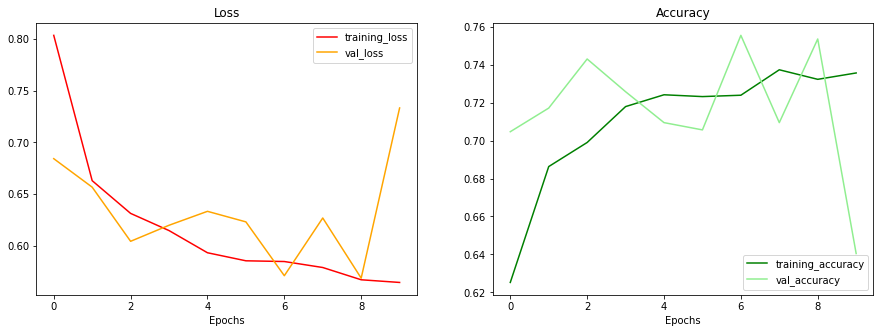

In [ ]:
helpers.plot_loss_curves(history)

In [ ]:
y_true, y_pred, metrics = helpers.evaluate_model_multi_batchdataset(
    multi_densenet_169_augmented, multi_test_data_augmented)
print(metrics)

{'accuracy': 0.7067307692307693, 'precision': 0.8004246617524859, 'recall': 0.7067307692307693, 'f1': 0.719800387881101}


In [ ]:
cm = confusion_matrix(y_true, y_pred)

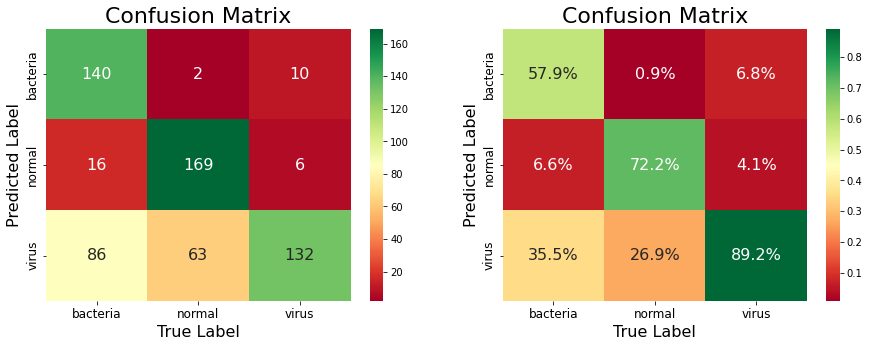

In [ ]:
helpers.plot_confusion_matrixes(cm.T, multi_class_names)

In [ ]:
binary_class_names

['normal', 'pneumonia']

In [10]:
weight_for_normal = (total_train_img_count /
                     normal_train_img_count) * (1 / len(binary_class_names))
weight_for_pneumonia = (total_train_img_count / pneumonia_train_img_count) * (
    1 / len(binary_class_names))

binary_class_weight = {0: weight_for_normal, 1: weight_for_pneumonia}

print(f'Weight for class 0: {weight_for_normal:.2f}')
print(f'Weight for class 1: {weight_for_pneumonia:.2f}')

Weight for class 0: 1.94
Weight for class 1: 0.67


In [ ]:
binary_densenet_169_augmented = models.clone_model(binary_densenet_169)
binary_densenet_169_augmented.set_weights(binary_densenet_169.get_weights())

binary_densenet_169_augmented.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(),
                                      metrics=["accuracy"])

history = binary_densenet_169_augmented.fit(
    binary_train_data_augmented,
    epochs=EPOCHS,
    validation_data=binary_val_data_augmented,
    class_weight=binary_class_weight)


Epoch 1/10
131/131 [==============================] - 153s 1s/step - loss: 0.4447 - accuracy: 0.7958 - val_loss: 0.2568 - val_accuracy: 0.9166
Epoch 2/10
131/131 [==============================] - 115s 814ms/step - loss: 0.2776 - accuracy: 0.8986 - val_loss: 0.3071 - val_accuracy: 0.8782
Epoch 3/10
131/131 [==============================] - 114s 812ms/step - loss: 0.2431 - accuracy: 0.9077 - val_loss: 0.2960 - val_accuracy: 0.8744
Epoch 4/10
131/131 [==============================] - 114s 813ms/step - loss: 0.2247 - accuracy: 0.9113 - val_loss: 0.2355 - val_accuracy: 0.9080
Epoch 5/10
131/131 [==============================] - 114s 816ms/step - loss: 0.2181 - accuracy: 0.9154 - val_loss: 0.2311 - val_accuracy: 0.9012
Epoch 6/10
131/131 [==============================] - 114s 813ms/step - loss: 0.2074 - accuracy: 0.9164 - val_loss: 0.2137 - val_accuracy: 0.9156
Epoch 7/10
131/131 [==============================] - 113s 808ms/step - loss: 0.2008 - accuracy: 0.9228 - val_loss: 0.2370 - va

{'accuracy': 0.8573717948717948, 'precision': 0.8443935926773455, 'recall': 0.9461538461538461, 'f1': 0.8923821039903265}


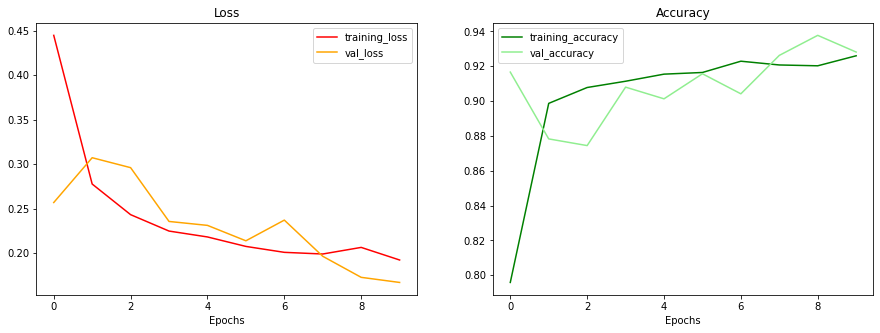

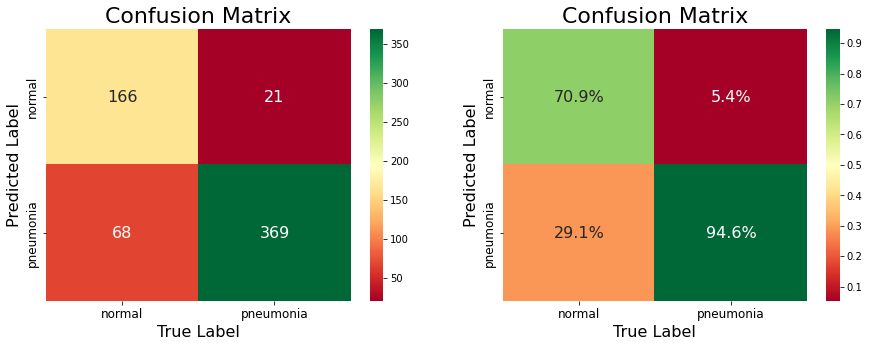

In [ ]:
helpers.plot_loss_curves(history)

y_true, y_pred, metrics = helpers.evaluate_model_binary_batchdataset(
    binary_densenet_169_augmented, binary_test_data_augmented)
print(metrics)

cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names)

In [ ]:
base_model = tf.keras.applications.DenseNet169(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_169 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_169")

binary_densenet_169.compile(loss='binary_crossentropy',
                            optimizer=optimizers.Adam(learning_rate=0.0001),
                            metrics=["accuracy"])

binary_densenet_169.summary()

history = binary_densenet_169.fit(binary_train_data_augmented,
                                  epochs=2 * EPOCHS,
                                  validation_data=binary_val_data_augmented,
                                  class_weight=binary_class_weight)

51888128/51877672 [==============================] - 1s 0us/step
Model: "binary_densenet_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling_laye  (None, 1664)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 254,273
Non-trainable params: 12,390,272
_________________________________________________________________
Epoch 1/20
131/131 [==========

{'accuracy': 0.8878205128205128, 'precision': 0.868663594470046, 'recall': 0.9666666666666667, 'f1': 0.9150485436893204}


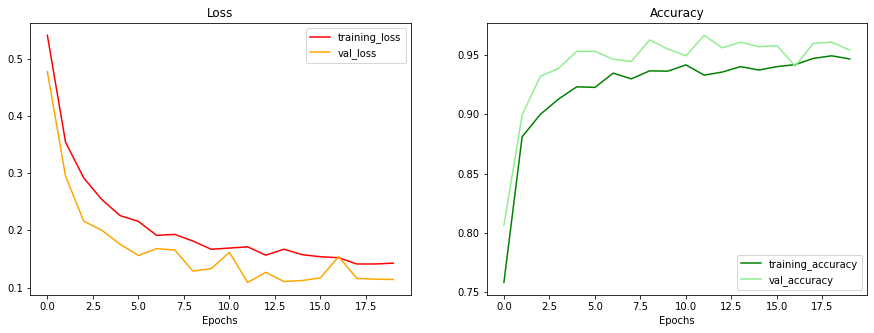

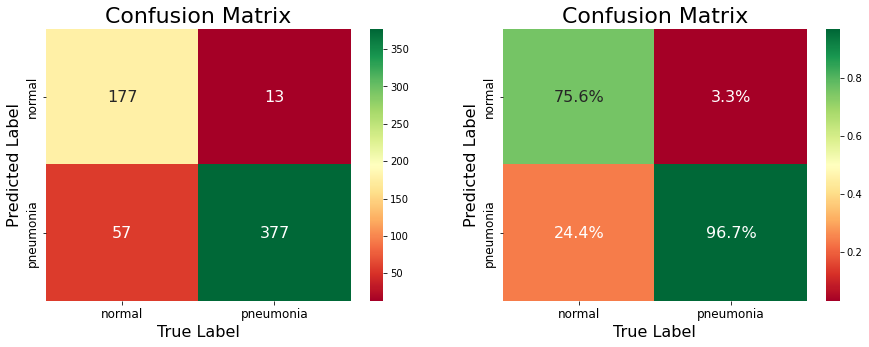

In [ ]:
helpers.plot_loss_curves(history)

y_true, y_pred, metrics = helpers.evaluate_model_binary_batchdataset(
    binary_densenet_169, binary_test_data_augmented)
print(metrics)

cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names)

In [11]:
base_model = tf.keras.applications.DenseNet169(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_169 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_169")

binary_densenet_169.compile(loss='binary_crossentropy',
                            optimizer=optimizers.Adam(learning_rate=0.0001),
                            metrics=["accuracy"])

binary_densenet_169.summary()

history = binary_densenet_169.fit(binary_train_data_augmented,
                                  epochs=2 * EPOCHS,
                                  validation_data=binary_val_data_augmented,
                                  class_weight=binary_class_weight)

Model: "binary_densenet_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling_laye  (None, 1664)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 536,513
Non-trainable params: 12,108,032
_________________________________________________________________
Epoch 1/20


2022-04-30 00:28:58.186078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-30 00:28:59.716302: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-30 00:28:59.726669: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


522/522 [==============================] - 56s 83ms/step - loss: 0.3524 - accuracy: 0.8466 - val_loss: 0.1683 - val_accuracy: 0.9415
Epoch 2/20
522/522 [==============================] - 41s 68ms/step - loss: 0.2356 - accuracy: 0.9140 - val_loss: 0.2187 - val_accuracy: 0.9099
Epoch 3/20
522/522 [==============================] - 41s 75ms/step - loss: 0.2264 - accuracy: 0.9147 - val_loss: 0.1701 - val_accuracy: 0.9329
Epoch 4/20
522/522 [==============================] - 46s 77ms/step - loss: 0.2219 - accuracy: 0.9087 - val_loss: 0.1441 - val_accuracy: 0.9453
Epoch 5/20
522/522 [==============================] - 41s 73ms/step - loss: 0.2000 - accuracy: 0.9216 - val_loss: 0.1470 - val_accuracy: 0.9434
Epoch 6/20
522/522 [==============================] - 41s 67ms/step - loss: 0.1805 - accuracy: 0.9281 - val_loss: 0.0953 - val_accuracy: 0.9636
Epoch 7/20


{'accuracy': 0.8878205128205128, 'precision': 0.8703703703703703, 'recall': 0.9641025641025641, 'f1': 0.9148418491484185}


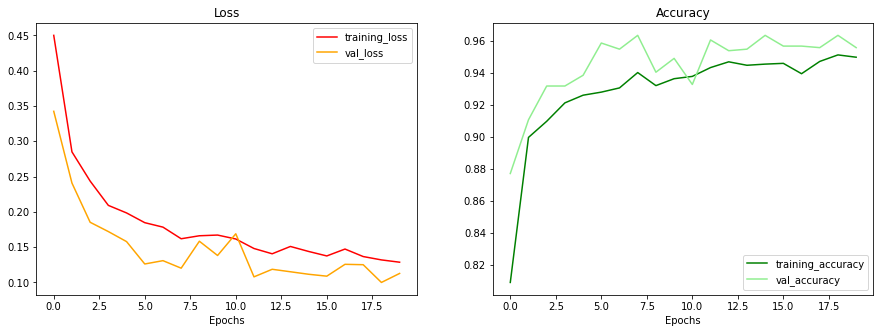

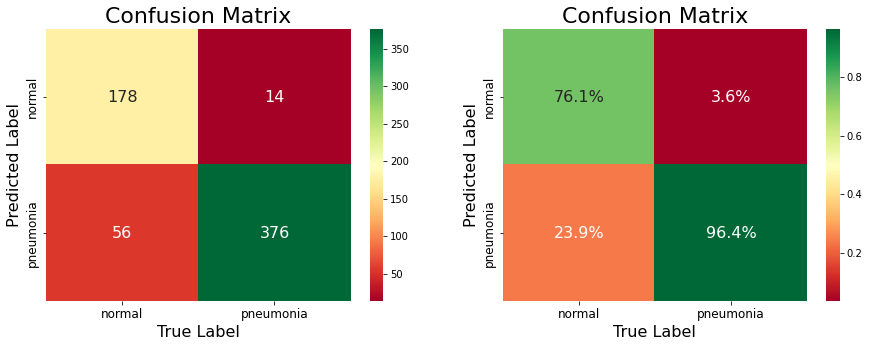

In [ ]:
helpers.plot_loss_curves(history)

y_true, y_pred, metrics = helpers.evaluate_model_binary_batchdataset(
    binary_densenet_169, binary_test_data_augmented)
print(metrics)

cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names)

In [12]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=
    20,  # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
    shear_range=0.2,  # shear the image
    zoom_range=0.2,  # zoom into the image
    width_shift_range=0.2,  # shift the image width ways
    height_shift_range=0.2,  # shift the image height ways
    horizontal_flip=True,  # flip the image on the horizontal axis
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1 / 255.)

# Turn it into batches
train_data_augmented = train_datagen_augmented.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='training')

val_data_augmented = train_datagen_augmented.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='validation')

test_data = test_datagen.flow_from_directory(directory=binary_test_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             seed=SEED)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
base_model = tf.keras.applications.DenseNet169(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_169 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_169")

binary_densenet_169.compile(loss='binary_crossentropy',
                            optimizer=optimizers.Adam(learning_rate=0.0001),
                            metrics=["accuracy"])

binary_densenet_169.summary()

history = binary_densenet_169.fit(train_data_augmented,
                                  epochs=2 * EPOCHS,
                                  validation_data=val_data_augmented,
                                  class_weight=binary_class_weight)

Model: "binary_densenet_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling_laye  (None, 1664)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 536,513
Non-trainable params: 12,108,032
_________________________________________________________________
Epoch 1/20


2022-04-29 22:21:17.411660: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-29 22:21:19.938874: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-29 22:21:19.948205: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


131/131 [==============================] - 76s 476ms/step - loss: 0.3270 - accuracy: 0.8653 - val_loss: 0.2751 - val_accuracy: 0.9003
Epoch 2/20
131/131 [==============================] - 58s 442ms/step - loss: 0.1872 - accuracy: 0.9307 - val_loss: 0.1531 - val_accuracy: 0.9473
Epoch 3/20
131/131 [==============================] - 57s 436ms/step - loss: 0.1390 - accuracy: 0.9542 - val_loss: 0.1108 - val_accuracy: 0.9559
Epoch 4/20
131/131 [==============================] - 56s 429ms/step - loss: 0.1190 - accuracy: 0.9600 - val_loss: 0.1208 - val_accuracy: 0.9559
Epoch 5/20
131/131 [==============================] - 57s 437ms/step - loss: 0.1004 - accuracy: 0.9674 - val_loss: 0.0824 - val_accuracy: 0.9712
Epoch 6/20
131/131 [==============================] - 57s 433ms/step - loss: 0.0987 - accuracy: 0.9667 - val_loss: 0.0912 - val_accuracy: 0.9693
Epoch 7/20
131/131 [==============================] - 57s 436ms/step - loss: 0.0862 - accuracy: 0.9700 - val_loss: 0.0687 - val_accuracy: 0.9

{'accuracy': 0.9310897435897436, 'precision': 0.9602122015915119, 'recall': 0.9282051282051282, 'f1': 0.9439374185136896}


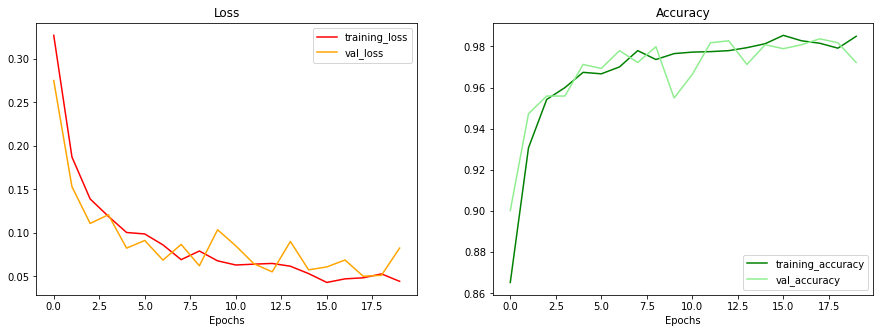

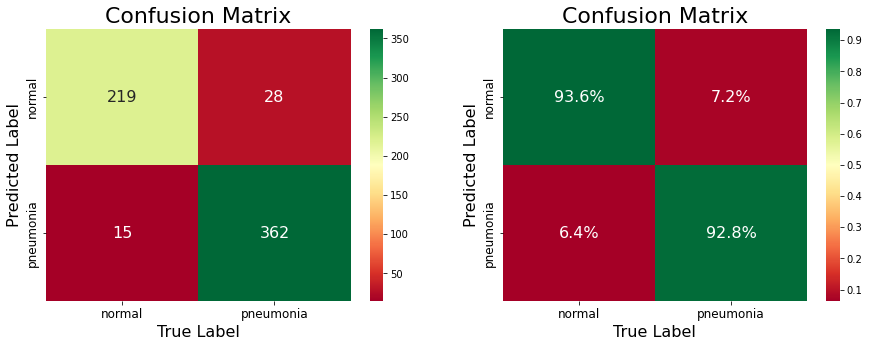

In [16]:
helpers.plot_loss_curves(history)

y_true, y_pred, metrics = helpers.evaluate_model_binary(
    binary_densenet_169, test_data)
print(metrics)

cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names)

In [ ]:
for score in [
        binary_evaluation_scores, binary_evaluation_scores_augmented,
        multi_evaluation_scores, multi_evaluation_scores_augmented
]:
    for _, _, metric in score:
        print(metric)
    print("\n")


{'accuracy': 0.625, 'precision': 0.625, 'recall': 1.0, 'f1': 0.7692307692307693}
{'accuracy': 0.7628205128205128, 'precision': 0.736328125, 'recall': 0.9666666666666667, 'f1': 0.8359201773835919}
{'accuracy': 0.7740384615384616, 'precision': 0.7408123791102514, 'recall': 0.982051282051282, 'f1': 0.844542447629548}


{'accuracy': 0.8044871794871795, 'precision': 0.79004329004329, 'recall': 0.9358974358974359, 'f1': 0.8568075117370892}
{'accuracy': 0.7676282051282052, 'precision': 0.7306967984934086, 'recall': 0.9948717948717949, 'f1': 0.8425624321389793}
{'accuracy': 0.625, 'precision': 0.625, 'recall': 1.0, 'f1': 0.7692307692307693}


{'accuracy': 0.38782051282051283, 'precision': 0.15040475016436555, 'recall': 0.38782051282051283, 'f1': 0.21674957067566766}
{'accuracy': 0.6153846153846154, 'precision': 0.6978032667730233, 'recall': 0.6153846153846154, 'f1': 0.592331390006908}
{'accuracy': 0.5192307692307693, 'precision': 0.637699881817529, 'recall': 0.5192307692307693, 'f1': 0.4562807

In [ ]:
binary_dense_model = models.load_model(
    'drive/MyDrive/tf_saved_models/binary_dense_model')
binary_tiny_vgg = models.load_model(
    'drive/MyDrive/tf_saved_models/binary_tiny_vgg')
binary_densenet_169 = models.load_model(
    'drive/MyDrive/tf_saved_models/binary_densenet_169')
binary_dense_model_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/binary_dense_model')
binary_tiny_vgg_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/binary_tiny_vgg')
binary_densenet_169_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/binary_densenet_169')

binary_models = [binary_dense_model, binary_tiny_vgg, binary_densenet_169]
binary_models_augmented = [
    binary_dense_model_augmented, binary_tiny_vgg_augmented,
    binary_densenet_169_augmented
]

multi_dense_model = models.load_model(
    'drive/MyDrive/tf_saved_models/multi_dense_model')
multi_tiny_vgg = models.load_model(
    'drive/MyDrive/tf_saved_models/multi_tiny_vgg')
multi_densenet_169 = models.load_model(
    'drive/MyDrive/tf_saved_models/multi_densenet_169')
multi_dense_model_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/multi_dense_model')
multi_tiny_vgg_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/multi_tiny_vgg')
multi_densenet_169_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/multi_densenet_169')

multi_models = [multi_dense_model, multi_tiny_vgg, multi_densenet_169]
multi_models_augmented = [
    multi_dense_model_augmented, multi_tiny_vgg_augmented,
    multi_densenet_169_augmented
]


In [ ]:
# y_pred = binary_dense_model.predict(binary_test_data)
# y_pred = np.round(y_pred.flatten())
# labels = np.concatenate([np.ravel(y.numpy()) for _, y in binary_test_data])

# acc = accuracy_score(labels, y_pred)
# pre = precision_score(labels, y_pred)
# rec = recall_score(labels, y_pred)
# f1 = f1_score(labels, y_pred)

In [ ]:
# fig = plt.figure(figsize=(16, 8))
# x = [float(f"{v:.2}") for v in [acc, pre, rec, f1]]
# hist = sns.barplot(x=np.array(x), y=np.array(["accuracy", "precision", "recall", "f1"]), palette="YlOrBr");
# hist.bar_label(hist.containers[0], padding=-40)
# hist.set_frame_on(False)